# Predicción de atrasao con XGBoost

XGBoost es un algoritmo rápido, eficiente y certero basado en Random Forest, o árboles de desisión. Tenemos suficientes observaciones en la data de entrenamiento para utilizar este modelo y relativamente pocas features. Finalmente tenemos features númericas y categoricas que se adaptan a este tipo de modelos.

In [5]:
import pandas as pd
import numpy as np

features_scl = pd.read_csv('../clean_data/synthetic_features.csv', parse_dates=['Fecha-I', 'Fecha-O'])
# Tipo vuelo en variable booleana
features_scl['tipo_b'] = np.where(features_scl['TIPOVUELO']=='N', 1, 0)
periodo_dia_ohe = pd.get_dummies(features_scl['periodo_dia'])
features_scl = features_scl.join(periodo_dia_ohe)
dianom_ohe = pd.get_dummies(features_scl['DIANOM'])
features_scl = features_scl.join(dianom_ohe)
opera_ohe = pd.get_dummies(features_scl['OPERA'])
features_scl = features_scl.join(opera_ohe)

# mean normalization
features_scl['norm_v_last_6'] = (
    (
        features_scl['v_last_6'] -
        features_scl['v_last_6'].mean()
    ) / 
    features_scl['v_last_6'].std()
)

In [6]:
# Columns into model
model_columns = [
    'temporada_alta', 'tipo_b',
    'mañana', 'noche', 'tarde', 
    'Domingo', 'Jueves', 'Lunes', 'Martes',
    'Miercoles', 'Sabado', 'Viernes', 'norm_v_last_6',
    'Aerolineas Argentinas', 'Aeromexico',
    'Air Canada', 'Air France', 'Alitalia', 'American Airlines', 'Austral',
    'Avianca', 'British Airways', 'Copa Air', 'Delta Air', 'Gol Trans',
    'Grupo LATAM', 'Iberia', 'JetSmart SPA', 'K.L.M.', 'Lacsa',
    'Latin American Wings', 'Oceanair Linhas Aereas',
    'Plus Ultra Lineas Aereas', 'Qantas Airways', 'Sky Airline',
    'United Airlines',
]

X = features_scl.loc[:,model_columns]
y = features_scl['atraso_15']

In [15]:
# fit xgboost on an imbalanced classification dataset
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier

# define model
model = XGBClassifier()
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)

print('Mean ROC AUC: %.5f' % mean(scores))

Mean ROC AUC: 0.68004


Esta configuración del modelo XGBoost tiene un roc_auc de 0.680, mejorando un poco frente al regresor lógistico (0.668)


### Otra iteración, utilizando class_wheight


In [21]:
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

model = XGBClassifier()

model.fit(X_train, y_train, sample_weight=sample_weights)

y_pred = model.predict(X_test)

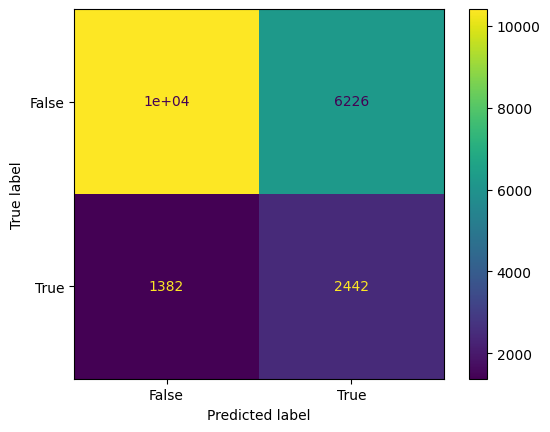

In [22]:
from sklearn import metrics
import matplotlib.pyplot as plt

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [23]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
## Accuracy
print('Accuracy', round(accuracy_score(y_test, y_pred),3))
## Precision
print('Precision', round(precision_score(y_test, y_pred),3))
## Recall
print('Recall', round(recall_score(y_test, y_pred),3))
## F1 Score
print('F1 Score', round(f1_score(y_test, y_pred),3))

Accuracy 0.628
Precision 0.282
Recall 0.639
F1 Score 0.391


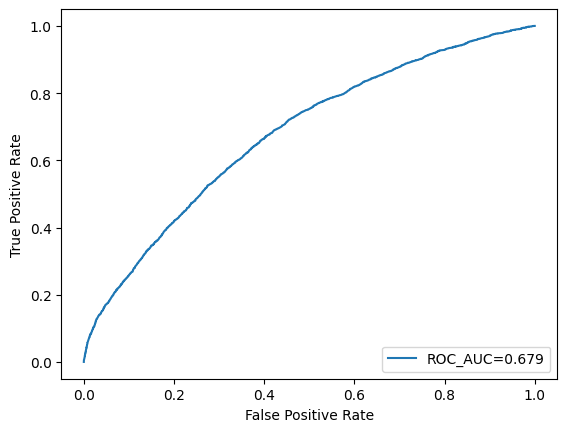

In [25]:
import matplotlib.pyplot as plt

y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="ROC_AUC="+str(round(auc,3)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

En este segundo XGBoost tenemos un auc de 0.679

### En ambos casos se mejoran los resultados del regresor logistico, pero sin mucha diferencia